In [1]:
import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


#Setting 1

In [3]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

batch_size=5


Get Input

In [5]:
import os

filename = []
category = []
refer = {}

data_root= 'c:/vs2015shareddata/dataset/flower_photos'
   
'''keras.utils.get_file('flower_photos',
  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
  untar=True)'''

folders = [x for x in os.listdir(data_root) if x.find('.') == -1]

i = 0
for folder in folders:
  
  refer.update({str(i):folder})
    
  folder = os.path.join(data_root,folder)
  files = os.listdir(folder)
  
  for file in files:
    
    file = os.path.join(folder, file)
    filename += [file]
    category += [str(i)]
    
  i += 1

total_category = len(refer)

Put into pandas

In [6]:
df = pd.DataFrame({
    'filename': filename,
    'category': category
})

In [7]:
df.sample(n=5)

,filename,category
3548,c:/vs2015shareddata/dataset/flower_photos\tuli...,4
33,c:/vs2015shareddata/dataset/flower_photos\dais...,0
83,c:/vs2015shareddata/dataset/flower_photos\dais...,0
711,c:/vs2015shareddata/dataset/flower_photos\dand...,1
3059,c:/vs2015shareddata/dataset/flower_photos\tuli...,4


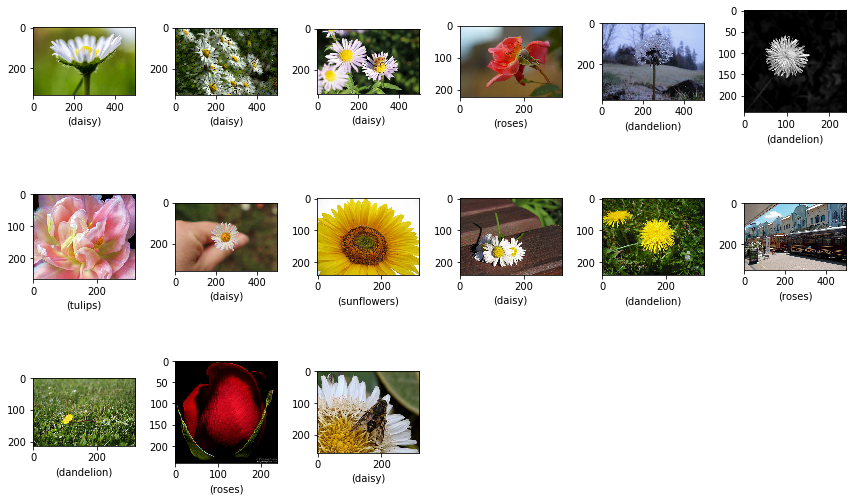

In [9]:
i = 0
plt.figure(figsize=(12,12))
for index, row in df.sample(n=15).iterrows():
  filename = row['filename']
  category = row['category']
  
  img = load_img(filename)
  plt.subplot(5, 6, i + 1)
  plt.imshow(img)
  plt.xlabel('(' + "{}".format(refer[category]) + ')' )
  
  i += 1
  
plt.tight_layout()
plt.show()


Split Data

In [12]:
df = df.sample(frac=1)

train_df, test_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

test_df, validation_df = train_test_split(test_df, test_size=0.50, random_state=42)
test_df = test_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [17]:
total_train = train_df.shape[0]
total_validation = validation_df.shape[0]
nb_samples = test_df.shape[0]

print(total_train,total_validation,nb_samples)

2569 551 550


Setting Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 2569 images belonging to 5 classes.
Found 551 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


Test Generator Image

Found 1 images belonging to 1 classes.


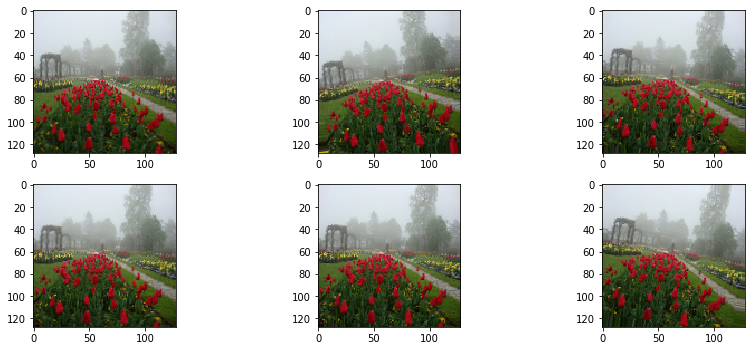

In [21]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE
)

plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#Setting 2

In [22]:
epochs=3 if FAST_RUN else 50

loss='categorical_crossentropy'


optimizer='adam'
#tf.global_variables_initializer().run()

#optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [33]:
#Callback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

modelCheckpoint= [ModelCheckpoint(filepath='model.weights.best.hdf5', monitor="val_acc", verbose = 1, save_best_only=True)]

import datetime
log_dir=".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction,tensorboard_callback]

Build Model

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

Train

In [34]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
513/513 [==============================] - 405s 790ms/step - loss: 1.6107 - acc: 0.4020 - val_loss: 1.3085 - val_acc: 0.5055
Epoch 2/3
513/513 [==============================] - 404s 788ms/step - loss: 1.4743 - acc: 0.4329 - val_loss: 1.3176 - val_acc: 0.4670
Epoch 3/3
513/513 [==============================] - 407s 793ms/step - loss: 1.4227 - acc: 0.4299 - val_loss: 1.3357 - val_acc: 0.4982

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


Save Model

In [35]:
model.save_weights("model.h5")

Visualization

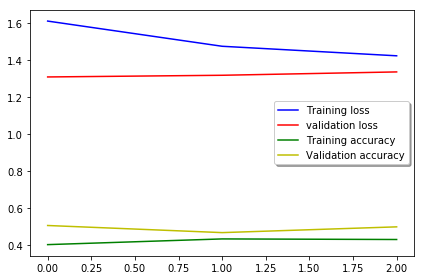

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.plot(history.history['acc'], color='g', label="Training accuracy")
plt.plot(history.history['val_acc'], color='y',label="Validation accuracy")

#plt.xticks(np.arange(1, epochs, 1))
#plt.yticks(np.arange(0, 1, 0.1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [61]:
print(log_dir)

from tensorboard import notebook
notebook.list()
notebook.display(port=6006, height=1000) 

%load_ext tensorboard.notebook
%tensorboard --logdir logs/scalars --host localhost --port 8088

.\logs\fit\20190403-163629
Known TensorBoard instances:
  - port 8088: logdir log_dir (started 1:04:01 ago; pid 2272)
  - port 6006: logdir log_dir (started 1:03:10 ago; pid 9212)
  - port 6006: logdir log_dir (started 1:02:45 ago; pid 9404)
Selecting TensorBoard with logdir log_dir (started 1:02:45 ago; port 6006, pid 9404).


The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


Launching TensorBoard...

OSError: [WinError 6] The handle is invalid

Prediction

In [37]:
import numpy as np
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [38]:
test_df[['0', '1', '2','3','4']] = pd.DataFrame(predict, index=test_df.index)

test_df['result'] = [np.argmax(i) for i in predict]
test_df['prob'] = [i[np.argmax(i)] for i in predict]
test_df.head(5)

,filename,category,0,1,2,3,4,result,prob
0,c:/vs2015shareddata/dataset/flower_photos\dand...,1,0.033844,0.097339,0.060370,0.140645,0.667803,4,0.667803
1,c:/vs2015shareddata/dataset/flower_photos\rose...,2,0.216793,0.038236,0.082987,0.529804,0.132181,3,0.529804
2,c:/vs2015shareddata/dataset/flower_photos\tuli...,4,0.681752,0.076906,0.107941,0.008029,0.125372,0,0.681752
3,c:/vs2015shareddata/dataset/flower_photos\dand...,1,0.340157,0.283759,0.060985,0.076206,0.238894,0,0.340157
4,c:/vs2015shareddata/dataset/flower_photos\rose...,2,0.094169,0.054951,0.064387,0.449357,0.337135,3,0.449357


Predicted Result

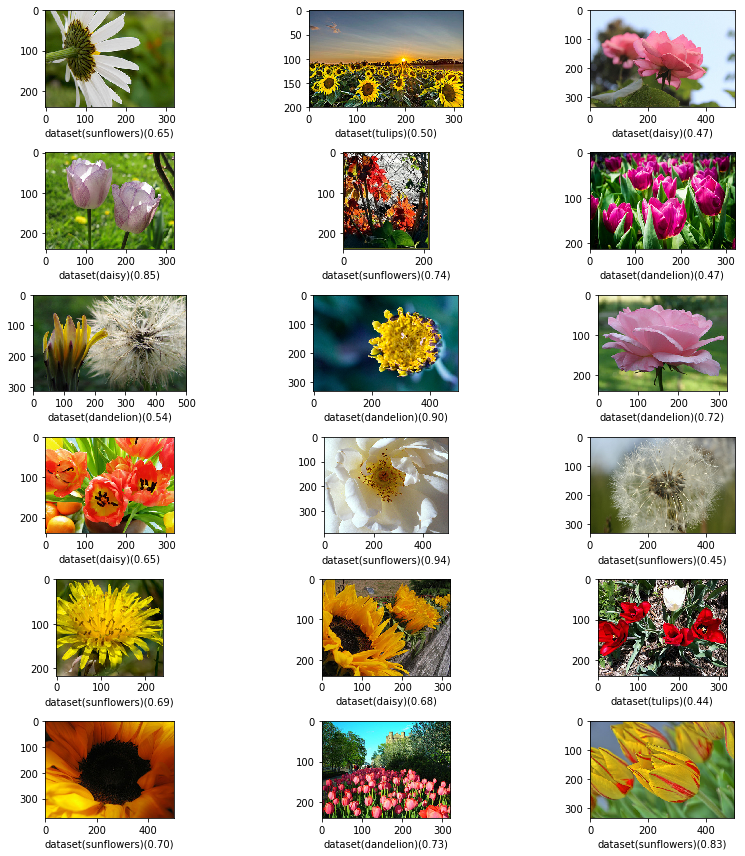

In [39]:
sample_test = test_df.sample(n = 18)
sample_test = sample_test.reset_index(drop=True)

plt.figure(figsize=(12,12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    result = row['result']
    probability = row['prob']
    img = load_img(filename)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename.split('/')[-2] + '(' + "{}".format(refer[str(result)]) + ')' '(' + "{:.2f}".format(probability) + ')')
plt.tight_layout()
plt.show()

Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('/').str[-1].str.split('.').str[0]
submission_df.drop(['filename','0','1','2','3','4'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [ ]:
result_df = pd.read_csv('submission.csv')
result_df.sample(n = 5)
